## Global imports

In [10]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from  arcgis.features  import FeatureLayer
from  arcgis.features  import Feature
from  arcgis.geometry  import Point
from  arcgis.geometry  import Polygon
from arcgis.gis import GIS


gis = GIS("https://org.maps.arcgis.com", "id", "pass")

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import pool

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=tf_config))

%matplotlib inline 
#import coco
config = pool.PoolConfig()


POOL_DIR = os.path.join(ROOT_DIR, "pools")
IMAGE_DIR = os.path.join(POOL_DIR, "tests")
IMAGE_DIR2 = os.path.join(POOL_DIR, "tests2")
# Local path to trained weights file
POOL_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_poolall.h5")
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained
model.load_weights(POOL_MODEL_PATH, by_name=True)

# "Pop-up pool" detection in the greater Geneva area

![Here, this is a pool!](presImages/thisisapool.png )

## What do we want : 
### We want to find pools in Greater Geneva and build a report of Pop-up pool for public information about water saving

### We want to detect "Pop-up pool" as standard ones are already registered with the topographic office
![](presImages/popupversusburied.png)

### We do that using machine learning and deep learning

# 1 - Finding data

Data is one of the most important part of machine learning, you need interesting data in order to train and validate your model.
There are different options.

## ArcGIS Living Atlas of the world

The greatest collection of GIS content in the world.

https://livingatlas.arcgis.com/en/

The interesting part for our story is imagery data.

![](presImages/livingatlas.png)

Some of these esri services can be exported on reasonable extent using https://github.com/Esri/TilePackageKreator
![](presImages/tpk.png)



## Open data website

You can also have a look on open data websites

https://opendata.swiss/
![](presImages/opendataS.png)

https://data.stadt-zuerich.ch
![](presImages/opendataZ.png)

https://ge.ch/sitg/
![](presImages/openData.png)

## Or your own data?

It could be images taken from drones, or your own licensed specific data, in the end it works out! 


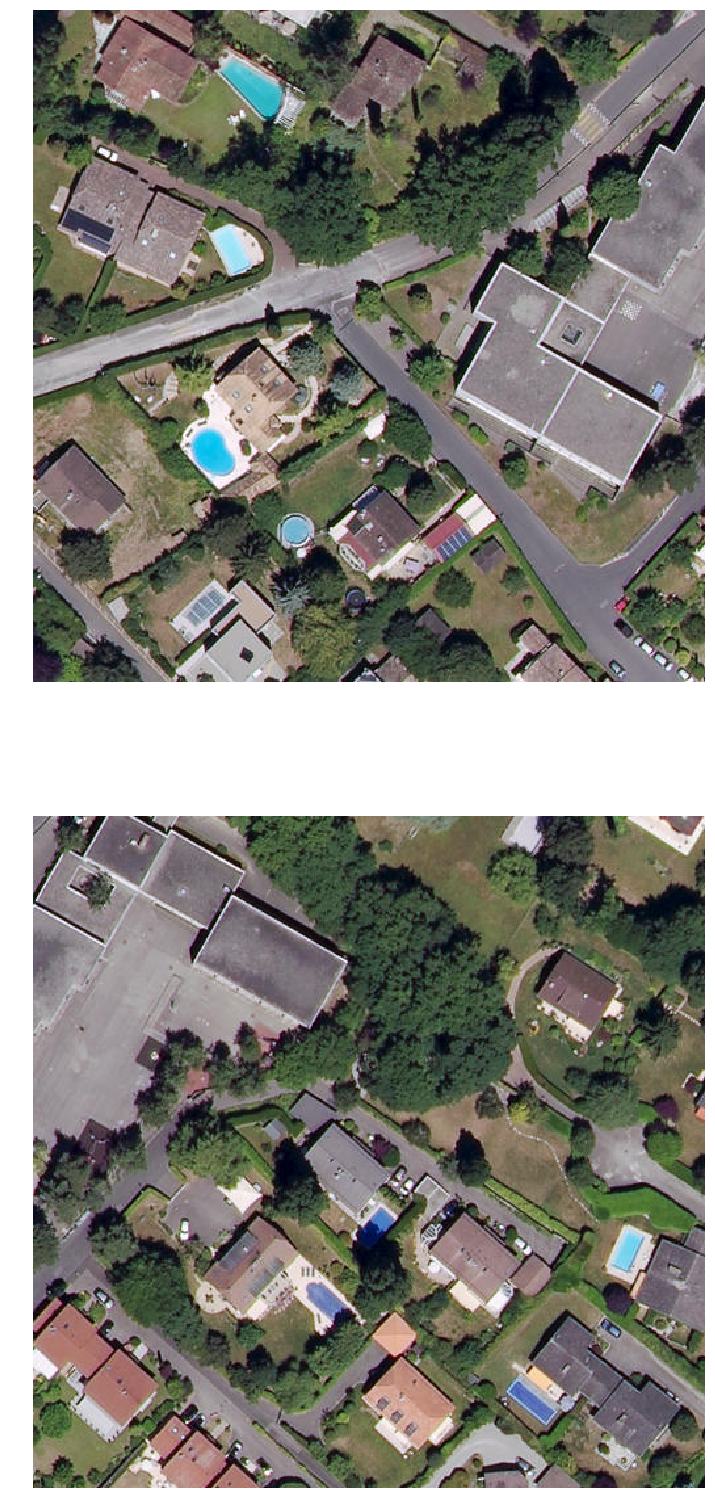

In [9]:
#display 2 random images of aerial photo
#filenames = next(os.walk(IMAGE_DIR2))[2]
filenames = ["geneva_288_314.jpg","geneva_288_315.jpg","geneva_288_316.jpg"]
filenames = np.random.choice(filenames,2)
images = []
for name in filenames:
    image = skimage.io.imread(os.path.join(IMAGE_DIR,name))
    images.append(image)
    
display_images(images,cols=1)

# 2 -  Choosing a Framework and training the model


![](presImages/deep-learning-developer-frameworks.png)

### We wanted to do image segmentation of pools
![Here, this is a pool!](presImages/thisisapool.png )

#### So we used an implementation of [Mask R-CNN](https://github.com/matterport/Mask_RCNN)

## Training the model 
You can either train the model from scratch
    * It takes time
    * It takes a lot of computer power
    * It takes a lot of labeled data

Or use "transfer learning" : use already trained model and add something more

For instance Mask R-CNN have been trained on the COCO dataset

![](presImages/cocoimage.png)
![](presImages/cocosample.png)



## Labeling data
Without labeled data : difficult to train a model.

There is always different tools and method to label data.

* ArcGIS Pro : Export training data for deep learning
![](presImages/pro.jpg)

* [VGG Image annotator](http://www.robots.ox.ac.uk/~vgg/software/via/)
![](presImages/vgg.png)


## Launch the model training

The training has been done using vgg labeled data as json

'''
{"geneva_288_314.jpg78647":{"filename":"geneva_288_314.jpg","size":78647,"regions":[{"shape_attributes":{"name":"polygon","all_points_x":[144,175,182,187,189,177,151],"all_points_y":[48,82,81,76,62,51,37]},"region_attributes":{}},{"shape_attributes":{"name":"polygon","all_points_x":[150,165,152,137],"all_points_y":[201,193,167,172]},"region_attributes":{}},{"shape_attributes":{"name":"polygon","all_points_x":[141,149,146,140,126,120,128,140,148],"all_points_y":[352,350,327,318,321,335,349,355,354]},"region_attributes":{}},{"shape_attributes":{"name":"polygon","all_points_x":[203,211,204,195,191,201],"all_points_y":[406,396,385,390,403,408]},"region_attributes":{}}],"file_attributes":{}}}

Then as specified in the readme, we just launched the following command and let it run for the night.
'''

'''
python3 pool.py train --dataset=C:\ML\Mask_RCNN\pools --weights=coco
'''


![](presImages/training.jpg)

# Verify and tune it on validation data

Here are some command to test and verify that the model is working as expected

In [12]:
# Load validation dataset
dataset = pool.PoolDataset()
dataset.load_pool(POOL_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 3
Classes: ['BG', 'pool']


C:\Users\cede\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


image ID: pool.geneva_288_316.jpg (2) C:\ML\Mask_RCNN\pools\val\geneva_288_316.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


C:\Users\cede\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:  324.00000  max:  714.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


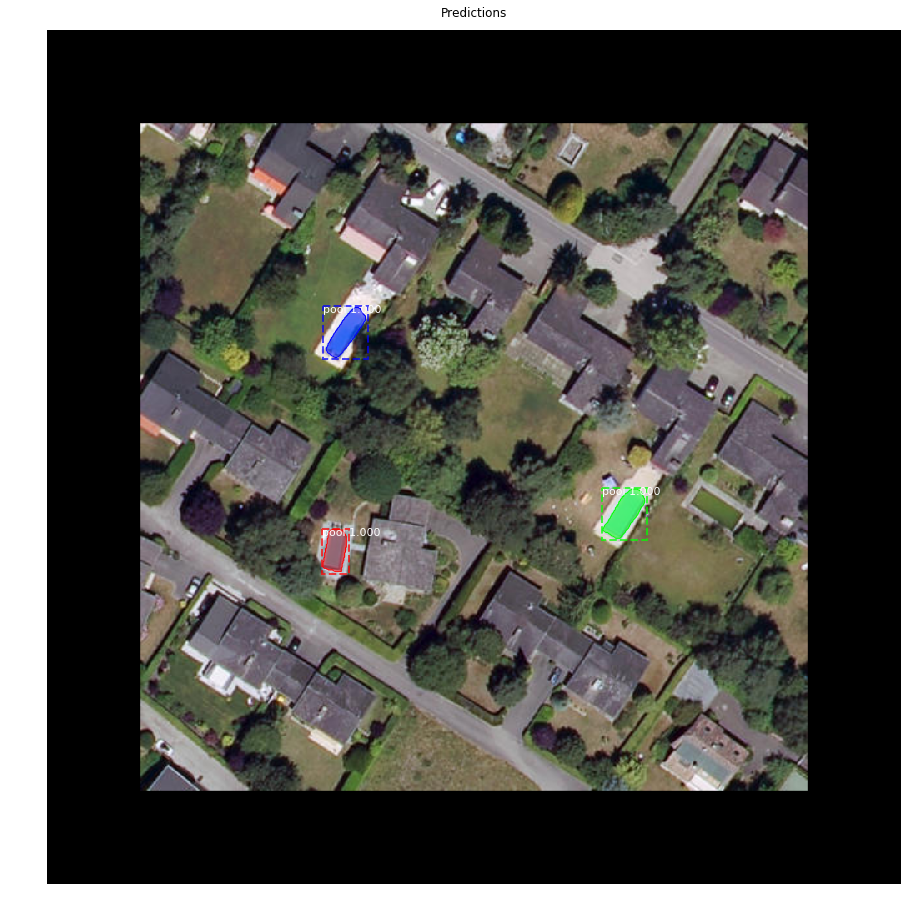

In [13]:

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Check it on final images

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8


C:\Users\cede\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


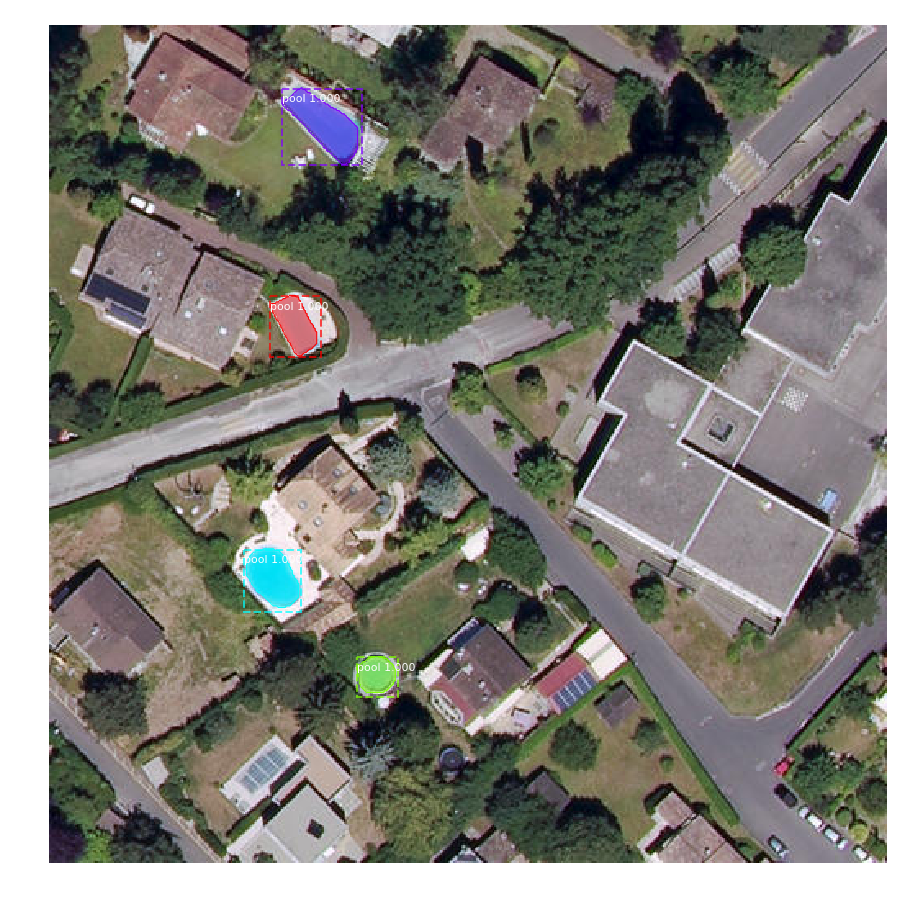

In [18]:
class_names = ['BG', 'pool']
# Load a random image from the images folder
#file_names = next(os.walk(IMAGE_DIR))[2]
filenames = ["geneva_288_314.jpg","geneva_288_315.jpg","geneva_288_316.jpg"]
name = random.choice(filenames)

image = skimage.io.imread(os.path.join(IMAGE_DIR,name))

# Run detection
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

### Find JUST the mask

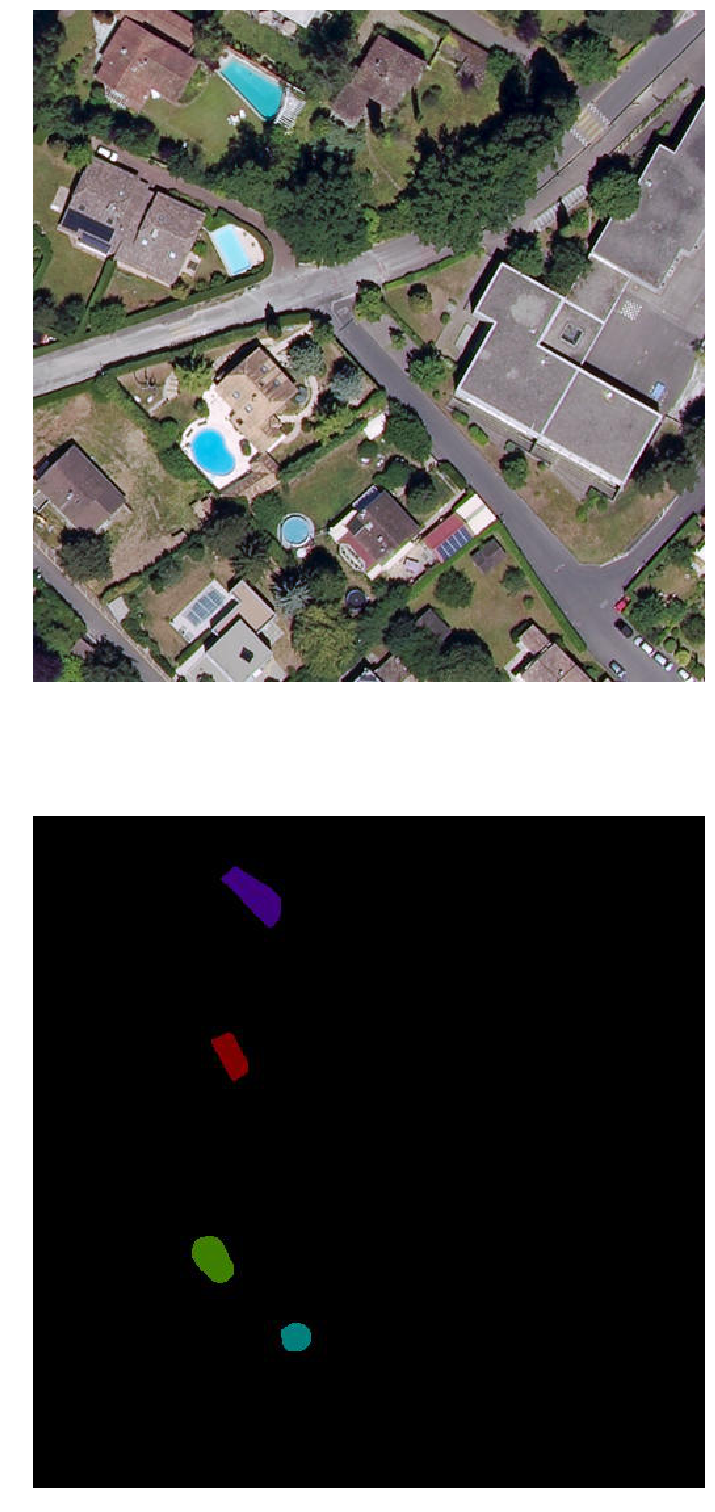

In [19]:
IMAGE_MASK_DIR = os.path.join(IMAGE_DIR,"mask")
# specific code added directly into the maskrcnn visualize.py to save the mask
# https://github.com/matterport/Mask_RCNN/pull/38/files
visualize.save_image(image,name,r['rois'], r['masks'],r['class_ids'], r['scores'],class_names,scores_thresh=0.8, save_dir=IMAGE_MASK_DIR, mode=3)
imageName = name+".jpg"
imageMask = skimage.io.imread(os.path.join(IMAGE_MASK_DIR,imageName))
display_images([image,imageMask],cols=1)


### Make polygons and find image coordinates from the mask

[ 84.21311475 181.        ]
[200.81818182 154.        ]
[355.53968254 144.        ]
[407.5920398 204.       ]


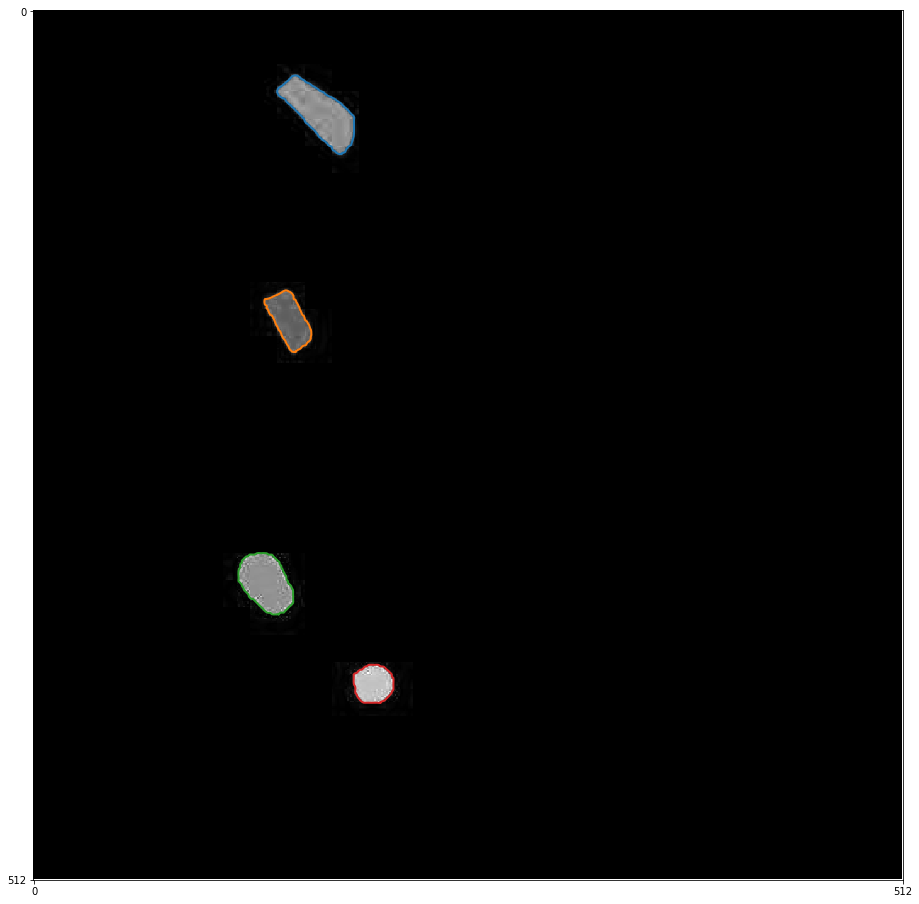

In [20]:

import numpy as np
import matplotlib.pyplot as plt


image = skimage.io.imread(os.path.join(IMAGE_MASK_DIR,imageName))
gray = image.sum(-1)
# Find contours at a constant value of 0.8
contours = skimage.measure.find_contours(gray, 100,fully_connected="high")


# Display the image and plot all contours found
#fig, ax = plt.subplots()
ax = get_ax(1)
ax.imshow(gray, interpolation='nearest', cmap=plt.cm.gray)


for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    print(contour[0])

ax.axis('image')
ax.set_xticks([0,512])
ax.set_yticks([0,512])

plt.show()


## Transform the polygon image coordinates into real world coordinates

In [21]:
#def
originX = 2462122.16
originY = 1160775.62
resolution = 0.26458386250105836
tileSize = 512
def getRealX(xTile,xInTile):
    return (((xTile * tileSize)) * resolution) + originX + ((xInTile) * resolution)

def getRealY(yTile,yInTile):
    return originY  - (((yTile * tileSize) ) * resolution) - ((yInTile-512) * resolution) - 512* resolution
firstpart,extension,extension2 = imageName.split('.')
imagebase,yTile,xTile = firstpart.split('_')
yTile = int(yTile)
xTile = int(xTile)
toAdd = []
for contour in contours:
    #one feature per contour
    #poly = Polygon()
    ptArr = []
    polyAttr = dict()
    for point in contour:
        ptArr.append([ getRealX(xTile,point[1]),getRealY(yTile,point[0])])
    print("Real coordinates in CH1903+ / LV95 :" + str(ptArr[0]))

    

Real coordinates in CH1903+ / LV95 :[2504706.6680856827, 1121738.860539869]
Real coordinates in CH1903+ / LV95 :[2504699.5243213954, 1121708.008720838]
Real coordinates in CH1903+ / LV95 :[2504696.87848277, 1121667.0719085652]
Real coordinates in CH1903+ / LV95 :[2504712.7535145204, 1121653.2996948287]


# 3 - Scale the process

## Using ArcGIS Online and ArcGIS API for Python

In [ ]:
poolFL = gis.content.get('id')
poolFL

### Loop on the data and import features

In [ ]:
#def
originX =2462122.16
originY = 1160775.62
resolution = 0.26458386250105836
tileSize = 512
def getRealX(xTile,xInTile):
    return (((xTile * tileSize)) * resolution) + originX + ((xInTile) * resolution)

def getRealY(yTile,yInTile):
    return originY  - (((yTile * tileSize) ) * resolution) - ((yInTile-512) * resolution) - 512* resolution

#layer to update
poolFL = gis.content.get('id').layers[0] 
#result = poolFL.delete_features(where="1=1")


filenames = next(os.walk(IMAGE_MASK_DIR))[2]
for imageName in filenames:
    
    image = skimage.io.imread(os.path.join(IMAGE_MASK_DIR,imageName))
    gray = image.sum(-1)
    # Find contours 
    contours = measure.find_contours(gray, 100,fully_connected="high")
    
    
    firstpart,extension,extension2 = imageName.split('.')
    imagebase,yTile,xTile = firstpart.split('_')
    yTile = int(yTile)
    xTile = int(xTile)
    toAdd = []
    for contour in contours:
        #one feature per contour
        #poly = Polygon()
        ptArr = []
        polyAttr = dict()
        for point in contour:
            #3pt = Point({"x" : getRealX(xTile,point[0]), "y" : getRealY(yTile,point[1]), "spatialReference" : {"wkid" : 2056}})
            ptArr.append([ getRealX(xTile,point[1]),getRealY(yTile,point[0])])

        poly = Polygon({"rings": [ptArr], "spatialReference" : {"wkid" : 2056}})
        polyAttr["imageName"] = imageName
        feat = Feature(poly,polyAttr)
        toAdd.append(feat)

    poolFL.edit_features(adds=toAdd)

# Filter and join features with official data

#### There is an official dataset of standard pools officially registered with the Geneva canton

https://ge.ch/sitg/fiche/1836


![](presImages/poolcanton.png)



#### So the process looks like this :
1. Create the features in ArcGIS Online.
2. Intersect the data with Swiss boundaries and delete what does not interesct.
3. Intersect the data with verified data from canton office and delete what does intersect.
4. Keep the pools without join
You can do that in ArcGIS Pro or directly with the Python API

![](presImages/poolfull.png)
Blue : Official pools, Violet : Deep learning image analysis pools







In [ ]:
#sample code for doing that in python
from arcgis.features.summarize_data import join_features

poolsInSwitzerlandFl = join_features(pools, inspection_lyr,
                                    join_operation='JoinOneToMany',
                                    spatial_relationship='intersects',
                                    output_name="poolsInSwitzerland")
poolsInSwitzerland

![](presImages/poolsdetected.png)

## Using the final webmap

In [4]:
# Create a map widget ()
poolWM = gis.content.get('id')
map1 = gis.map(poolWM)
map1

MapView(layout=Layout(height='400px', width='100%'))

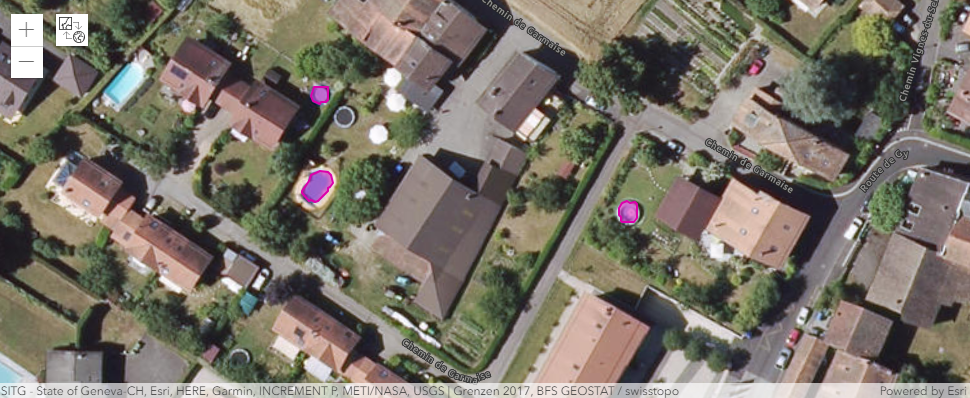

## Geocoding and reporting

### Reverse - Geocoding

In [32]:
# 
from arcgis.geometry import Geometry
from  arcgis.geocoding import reverse_geocode
poolToGeocodeFl= gis.content.get('id').layers[0]

In [ ]:
poolToGeocodeFeatures  = poolToGeocodeFl.query()
#get a point of polygon and reverse geocode it then update the featurelyer.
updat = []
i = 0
for pool in poolToGeocodeFeatures:
    firstPoint = pool.geometry["rings"][0][0]
    pt = Geometry({
    "x": firstPoint[0],
    "y": firstPoint[1],
    "spatialReference": {
        "wkid": 2056
        }
    })
    result = reverse_geocode(pt, lang_code="de")
    pool.attributes["address"] = result["address"]["LongLabel"]
    updat.append(pool)
    if(i%100 == 0):
        poolToGeocodeFl.edit_features(updates=updat)
        updat = []
    i = i+1
poolToGeocodeFl.edit_features(updates=updat)

In [33]:
poolToReport = poolToGeocodeFl.query()

In [ ]:
poolDf = poolToReport.df
poolDf.head()
poolDf['volume'] = poolDf['area'] *1.5
poolDf[['OBJECTID','address','area','volume','imageName']]

![](presImages/imageReports.png)

# Cubic meter statistics

In [46]:
# statitiques cubic meter
Total = poolDf['volume'].sum()
print (Total)

70544.3282807727


### 70 544 m3
That's equivalent to 28 olympic pools !

or next to 90 000 helicopter trips in the Alps.

To understand why the helicopter reference : https://www.swissinfo.ch/eng/heat-wave-continues_army-helicopters-bring-water-for-thirsty-cows/44299458


![](presImages/helicopter.jpg)

